# A/B-тесты. Задание 2

Эксперимент проходил с 2022-04-24 по 2022-04-30 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Задача — проанализировать данные АB-теста. 

* Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr ($\alpha=5$) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
* Сравнить данные этими тестами. А еще посмотреть на распределения глазами. Почему тесты сработали так как сработали? 
* Описать потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа.
* Написать рекомендацию, стоит ли раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

________________________

Добавляем то, что пригодится

In [1]:
import pandahouse
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})

Сформулируем запрос

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
}

q = 'SELECT \
    user_id, toDate(time) as day,\
    countIf(action=\'view\') as views, \
    countIf(action=\'like\') as likes, \
    likes / views as ctr, exp_group \
    FROM {db}.feed_actions \
    where (toDate(time) >= \'2022-04-24\' and \
    toDate(time) <= \'2022-04-30\' and \
    exp_group in (1, 2))\
    group by user_id, day, exp_group\
    order by day, user_id'

df = pandahouse.read_clickhouse(q, connection=connection)

Посмотрим, что получилось:

In [3]:
df.head()

,user_id,day,views,likes,ctr,exp_group
0,216,2022-04-24,11,0,0.000000,1
1,224,2022-04-24,9,3,0.333333,2
2,228,2022-04-24,22,2,0.090909,2
3,276,2022-04-24,32,11,0.343750,1
4,310,2022-04-24,56,11,0.196429,1


На всяки случай, взглянем на количество пользователей в каждой из выбранных групп: необходимо, чтобы разница была незначительной

In [4]:
df['exp_group'].value_counts()

1    19468
2    19154
Name: exp_group, dtype: int64

Пусть для каждой группы будет свой датафрейм

In [5]:
df_control = df.loc[df['exp_group'] == 1]
df_test = df.loc[df['exp_group'] == 2]

Запускаем t-тесты

In [6]:
ctr_control = df_control['ctr']    
ctr_test = df_test['ctr']
t_p_val = stats.ttest_ind(ctr_control, ctr_test, equal_var=False)
mw_p_val = stats.mannwhitneyu(ctr_control, ctr_test)
t_p_val, mw_p_val

(Ttest_indResult(statistic=4.3154164566734305, pvalue=1.5976886967274757e-05),
 MannwhitneyuResult(statistic=210583134.0, pvalue=1.3469462778149872e-107))

Ради интереса рассмотрим пуассоновский бутстреп, прослушанный в лекции и скопированный из конспекта :)

In [7]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [8]:
gctr_control, gctr_test = bootstrap(df_control.likes.to_numpy(), df_control.views.to_numpy(),
                                   df_test.likes.to_numpy(), df_test.views.to_numpy())

## Результаты

Гистограмма ctr

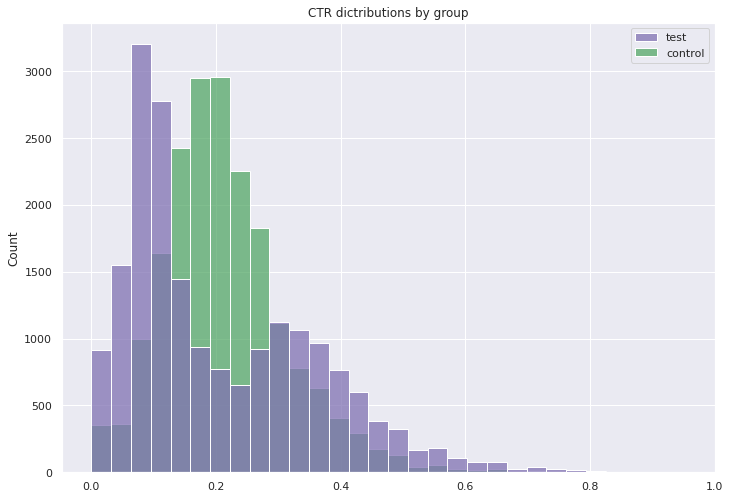

In [9]:
sns.histplot(data={'test': ctr_test, 'control': ctr_control}, bins=30, palette=['m', 'g'])
plt.title('CTR dictributions by group')
plt.show()

Судя по гистограмме, прогноз не утешительный. CTR явно не изменился в нужную сторону. Получилось корявое распределение с 2 пиками. Тестовые статистические характеристики очевидно меньше контрольных значений.

Проверим, какие статистики для ctr получились в 1 и 2 группах:

In [10]:
print(f'средний CTR в группе 1 (контрольная) = {ctr_control.mean()}')
print(f'средний CTR в группе 2 (тестовая) = {ctr_test.mean()}')
print(f'медиана CTR в группе 1 (контрольная) = {ctr_control.median()}')
print(f'медиана CTR в группе 2 (тестовая) = {ctr_test.median()}')
print(f'моды CTR в группе 1 (контрольная) = {ctr_control.mode()}')
print(f'моды CTR в группе 2 (тестовая) = {ctr_test.mode()}')

средний CTR в группе 1 (контрольная) = 0.21349817934160273
средний CTR в группе 2 (тестовая) = 0.20783215599430105
медиана CTR в группе 1 (контрольная) = 0.2
медиана CTR в группе 2 (тестовая) = 0.15
моды CTR в группе 1 (контрольная) = 0    0.2
dtype: float64
моды CTR в группе 2 (тестовая) = 0    0.0
dtype: float64


Построим гистограмму для пуассоновского бутсрепа:

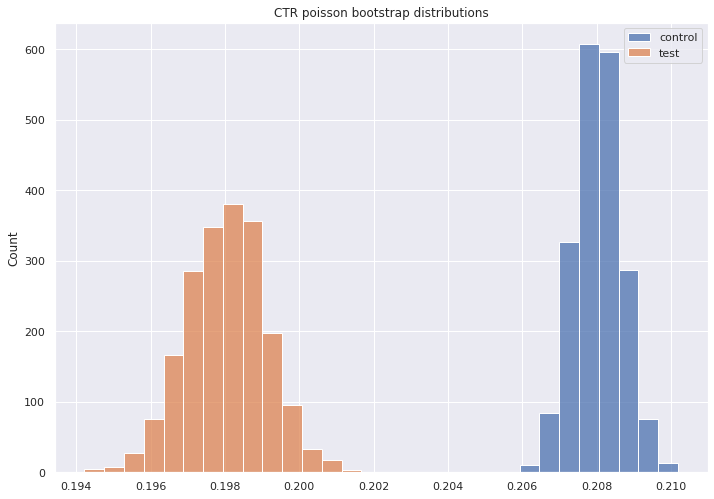

In [11]:
sns.histplot(data={'control': gctr_control, 'test': gctr_test}, bins=30)
plt.title('CTR poisson bootstrap distributions')
plt.show()

Хорошо видно, что распределение тестового среднего CTR из бутстреп даже не задевает область контрольного распределения. Не рекомендую.